Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.Z5RD63_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1179s 2s/step - accuracy: 0.7216 - loss: 0.5351 - precision: 0.7181 - recall: 0.7383 - val_accuracy: 0.8903 - val_loss: 0.2621 - val_precision: 0.8708 - val_recall: 0.9111
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1216s 2s/step - accuracy: 0.8948 - loss: 0.2517 - precision: 0.8903 - recall: 0.8979 - val_accuracy: 0.9119 - val_loss: 0.2134 - val_precision: 0.9003 - val_recall: 0.9207
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1159s 2s/step - accuracy: 0.9112 - loss: 0.2135 - precision: 0.9119 - recall: 0.9069 - val_accuracy: 0.9200 - val_loss: 0.1955 - val_precision: 0.9152 - val_recall: 0.9221
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 1133s 2s/step - accuracy: 0.9189 - loss: 0.1935 - precision: 0.9207 - recall: 0.9158 - val_accuracy: 0.9194 - val_loss: 0.1893 - val_precision

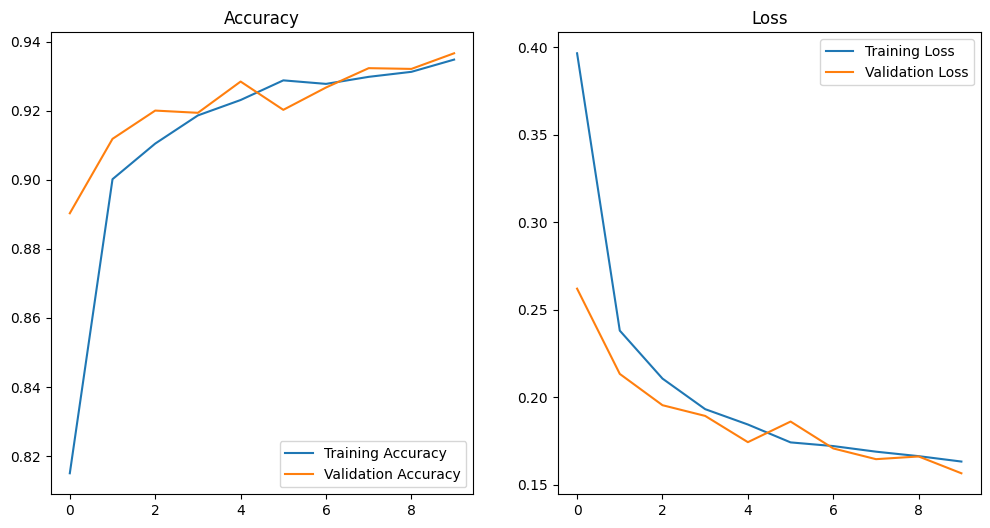

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


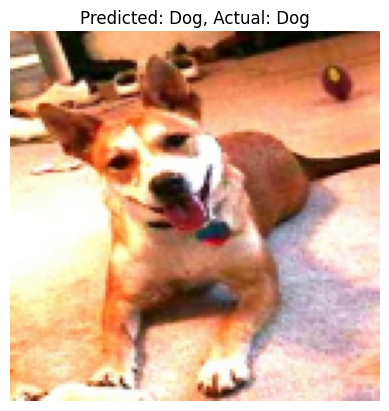

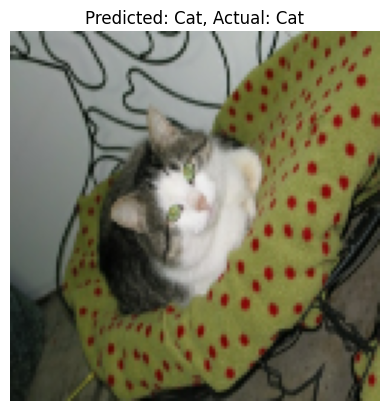

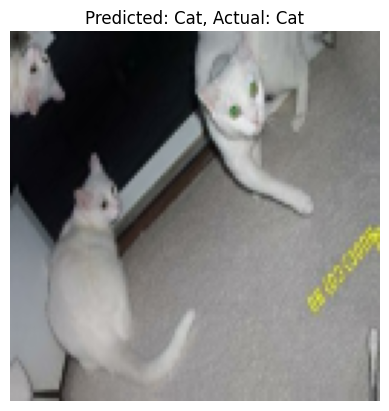

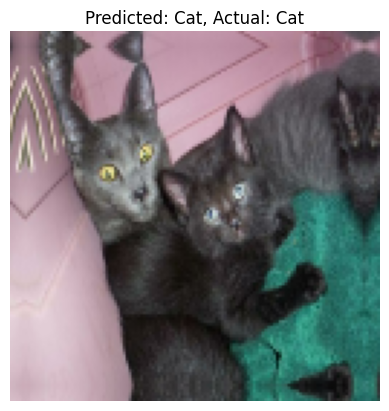

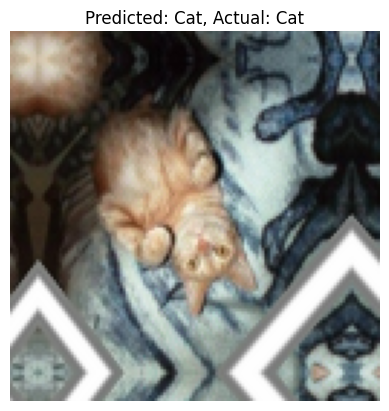

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the cats_vs_dogs dataset
dataset, info = tfds.load('cats_vs_dogs', as_supervised=True, with_info=True)

# Preprocessing constants
IMG_SIZE = 128  # Resize images to 128x128
BATCH_SIZE = 32
EPOCHS = 10

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Preprocessing function
def preprocess_image(image, label):
    image = data_augmentation(image)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

# Preprocess datasets
train_dataset = dataset['train']
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Create validation set
val_split = 0.2  # Use 20% of data for validation
val_dataset = train_dataset.take(int(len(train_dataset) * val_split))
train_dataset = train_dataset.skip(int(len(train_dataset) * val_split))

# Use a pre-trained model with transfer learning
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Build the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Save the model
model.save('cats_vs_dogs_model.h5')

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Visualize predictions
for image_batch, label_batch in train_dataset.take(1):
    predictions = model.predict(image_batch)
    for i in range(5):  # Display 5 samples
        plt.imshow(image_batch[i].numpy())
        plt.title(f"Predicted: {'Dog' if predictions[i] > 0.5 else 'Cat'}, "
                  f"Actual: {'Dog' if label_batch[i] == 1 else 'Cat'}")
        plt.axis('off')
        plt.show()
